In [1]:
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

import logging

In [2]:
class Diffusion:
    def __init__(self, noise_steps=1000, beta_start=1e-4, beta_end=0.02, img_size=64, device="cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        # Initialize betas and alphas
        self.betas = self.prepare_noise_schedule().to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_hat = torch.cumprod(self.alphas, dim=0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)
    
    def noise_images(self, x, t):
        # We can add noise until time t iteratively, but 
        # we can also do it in one go from using the cumulative product of alphas.
        # x initially starts of at time 0.
        # noise = torch.randn_like(x)

        sqrt_alpha_hat = torch.sqrt(self.alphas_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1.0 - self.alphas_hat[t])[:, None, None, None]
        eps = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * eps, eps
    
    def sample_timesteps(self, n):
        return torch.randint(low=0, high=self.noise_steps, size=(n,))
    
    def sample(self, model, n):
        logging.info(f"Sampling {n} new images...")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 3, self.img_size, self.img_size), device=self.device)
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t  = (torch.ones(n) * i).long().to(self.device)

                predicted_noise = model(x, t)
                alpha = self.alphas[t][:, None, None, None]
                alpha_hat = self.alphas_hat[t][:, None, None, None]
                beta = self.betas[t][:, None, None, None]

                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = 0

                x = (1. / torch.sqrt(alpha)) \
                    * (x - ((1. -alpha) / torch.sqrt(1. - alpha_hat)) * predicted_noise) \
                    + torch.sqrt(beta) * noise
        model.train()
        x = x.clamp(-1, 1) / 2
        x = (x * 255).type(torch.uint8) # Bring back to pixel range (0-255)
        return x

In [3]:
import torch.nn.functional as F
from torchinfo import summary

# class DoubleConv(nn.Module):
#     def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
#         super().__init__()
#         if not mid_channels:
#             mid_channels = out_channels
#         self.residual = residual
#         self.double_conv = nn.Sequential(
#             nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
#             nn.GroupNorm(1, mid_channels),
#             nn.GELU(),
#             nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
#             nn.GroupNorm(1, out_channels),
#         )
    
#     def forward(self, x):
#         if self.residual:
#             return F.gelu(x + self.double_conv(x))
#         else:
#             return self.double_conv(x)

# class Down(nn.Module):
#     def __init__(self, in_channels, out_channels, emb_dim=256):
#         super().__init__()
#         self.maxpool_conv = nn.Sequential(
#             nn.MaxPool2d(2),
#             DoubleConv(in_channels, in_channels, residual=True),
#             DoubleConv(in_channels, out_channels),
#         )

#         # Embedding layer to condition on time
#         self.emb_layer = nn.Sequential(
#             nn.SiLU(),
#             nn.Linear(
#                 emb_dim,
#                 out_channels,
#             )
#         )
    
#     def forward(self, x, t):
#         x = self.maxpool_conv(x)
#         emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
#         x = x + emb
#         return x
    
# class Up(nn.Module):
#     def __init__(self, in_channels, out_channels, emb_dim=256):
#         super().__init__()
#         self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
#         self.conv = nn.Sequential(
#             DoubleConv(in_channels, in_channels, residual=True),
#             DoubleConv(in_channels, out_channels, in_channels // 2)
#         )

#         self.emb_layer = nn.Sequential(
#             nn.SiLU(),
#             nn.Linear(
#                 emb_dim,
#                 out_channels,
#             )
#         )
    
#     def forward(self, x, skip_x, t):
#         # Take in skip connections (ideally from the downsampling path aka encoder)
#         x = self.up(x)
#         x = torch.cat([x, skip_x], dim=1)
#         x = self.conv(x)
#         emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
#         return x + emb
    
# class SelfAttention(nn.Module):
#     def __init__(self, channels, size):
#         super().__init__()
#         self.channels = channels
#         self.size = size
#         self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
#         self.ln = nn.LayerNorm([channels])
#         self.ff_self = nn.Sequential(
#             nn.LayerNorm([channels]),
#             nn.Linear(channels, channels),
#             nn.GELU(),
#             nn.Linear(channels, channels),
#         )

#     def forward(self, x):

#         # Flatten image shapes then bringing channel axes to the last dimension
#         # so that attention can work properly.
#         # >>> x = torch.randn((1, 128, 32, 32))
#         # >>> x.view(-1, 128, 32*32).swapaxes(1,2).shape
#         # torch.Size([1, 1024, 128])
#         x = x.view(-1, self.channels, self.size + self.size).swapaxes(1, 2)
#         x_ln = self.ln(x)
#         attention_value, _ = self.mha(x_ln, x_ln, x_ln)
#         attention_value = attention_value + x
#         attention_value = self.ff_self(attention_value) + attention_value
#         return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


# class UNet(nn.Module):
#     def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
#         super().__init__()
#         self.device = device
#         self.time_dim = time_dim

#         self.inc = DoubleConv(c_in, 64)
#         self.down1 = Down(64, 128)
#         self.sa1 = SelfAttention(128, 32)
#         self.down2 = Down(128, 256)
#         self.sa2 = SelfAttention(256, 16)
#         self.down3 = Down(256, 256)
#         self.sa3 = SelfAttention(256, 8)

#         self.bot1 = DoubleConv(256, 512)
#         self.bot2 = DoubleConv(512, 512)
#         self.bot3 = DoubleConv(512, 256)

#         self.up1 = Up(512, 128)
#         self.sa4 = SelfAttention(128, 16)
#         self.up2 = Up(256, 64)
#         self.sa5 = SelfAttention(64, 32)
#         self.up3 = Up(128, 64)
#         self.sa6 = SelfAttention(64, 64)
#         self.outc = nn.Conv2d(64, c_out, kernel_size=1)

#     def pos_encoding(self, t, channels):
#         """
#         Sinuisoidal embedding
#         """
#         inv_freq = 1.0 / (
#             10000 ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
#         )
#         pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
#         pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
#         pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
#         return pos_enc
    
#     def forward(self, x, t):
#         t = t.unsqueeze(-1).type(torch.float)
#         t = self.pos_encoding(t, self.time_dim)

#         x1 = self.inc(x)
#         x2 = self.down1(x1, t)
#         x2 = self.sa1(x2)
#         x3 = self.down2(x2, t)
#         x3 = self.sa2(x3)
#         x4 = self.down3(x3, t)
#         x4 = self.sa3(x4)
        
#         x4 = self.bot1(x4, t)
#         x4 = self.bot2(x4, t)
#         x4 = self.bot3(x4, t)

#         x = self.up1(x4, x3, t)
#         x = self.sa4(x)
#         x = self.up2(x, x2, t)
#         x = self.sa5(x)
#         x = self.up3(x, x1, t)
#         x = self.sa6(x)
#         output = self.outc(x)
#         return output

class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super().__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
            return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, t):
        x = self.maxpool_conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.conv = nn.Sequential(
            DoubleConv(in_channels, in_channels, residual=True),
            DoubleConv(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(
                emb_dim,
                out_channels
            ),
        )

    def forward(self, x, skip_x, t):
        x = self.up(x)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        emb = self.emb_layer(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return x + emb


class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output


class UNet_conditional(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, num_classes=None, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        self.sa3 = SelfAttention(256, 8)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output






In [4]:
%%script False
### Test the model with a random input
## Construct model
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
diffusion = Diffusion(device=device)
model = UNet(device=device).to(device)

print(summary(model))
print(f"GPU usage: {torch.cuda.memory_allocated()*1e-9:.2f} GB")

## Test the model with a random input
x = torch.randn((1, 3, 64, 64)).to(device)
t = diffusion.sample_timesteps(x.shape[0]).to(device)

with torch.no_grad():
    output = model(x, t)
    print(f"Output {output.shape}:\n{output}")


Couldn't find program: 'False'


### Training with data

c:\Users\thanh\miniconda3\envs\deepl\lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.6862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..2

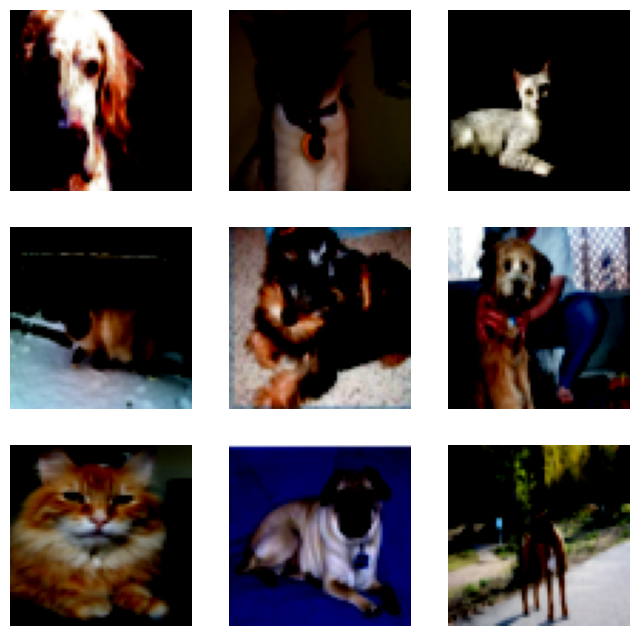

In [5]:
import torchvision
import matplotlib.pyplot as plt

from torchvision.transforms import v2

image_size = 64
transforms = v2.Compose([
    # v2.Resize(size=(64, 64)),
    v2.Resize(80),
    v2.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    v2.ToDtype(torch.float32, scale=True),
    v2.ToTensor(),
    v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
training_data = torchvision.datasets.OxfordIIITPet("./datasets/OxfordIIITPet", 
                                                 download=True, 
                                                 transform=transforms,
                                                 )

# Visualize some images from the dataset
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    # plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.swapaxes(0, 2).swapaxes(0, 1))  # Convert from CxHxW to HxWxC for matplotlib
plt.show()

In [6]:
%%script False
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Couldn't find program: 'False'


### Training

In [ ]:
### Training loop
def train(dataset, batch_size=12, epochs=100, lr=1e-4, device="cuda"):
    diffusion = Diffusion(img_size=64, device=device)
    model = UNet(device=device).to(device)
    dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)


    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)     # TODO: Investigate and replace with AdamW?

    criterion = nn.MSELoss()

    losses = []
    for epoch in range(epochs):  # Example: 10 epochs
        print(f"Epoch {epoch+1}/{epochs}")
        epoch_loss = 0.0
        pbar = tqdm(dataloader)
        for i, (images, _) in enumerate(pbar):
            images = images.to(device)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            x_t, noise = diffusion.noise_images(images, t)

            predicted_noise = model(x_t, t)
            loss = criterion(predicted_noise, noise)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())
            epoch_loss += loss.item()
        
        epoch_loss /= len(dataloader)
        losses.append(epoch_loss)

    return model, diffusion, losses 


### Setup training
train(training_data, batch_size=8, epochs=100, lr=1e-4)

Epoch 1/500


100%|██████████| 460/460 [11:30<00:00,  1.50s/it, MSE=0.0487]


Epoch 2/500


100%|██████████| 460/460 [11:09<00:00,  1.46s/it, MSE=0.0872]


Epoch 3/500


100%|██████████| 460/460 [11:06<00:00,  1.45s/it, MSE=0.0622]


Epoch 4/500


100%|██████████| 460/460 [11:03<00:00,  1.44s/it, MSE=0.0229]


Epoch 5/500


100%|██████████| 460/460 [10:09<00:00,  1.32s/it, MSE=0.0759] 


Epoch 6/500


100%|██████████| 460/460 [10:03<00:00,  1.31s/it, MSE=0.116]  


Epoch 7/500


100%|██████████| 460/460 [10:03<00:00,  1.31s/it, MSE=0.105]  


Epoch 8/500


100%|██████████| 460/460 [10:10<00:00,  1.33s/it, MSE=0.0128] 


Epoch 9/500


100%|██████████| 460/460 [10:18<00:00,  1.34s/it, MSE=0.0345] 


Epoch 10/500


100%|██████████| 460/460 [10:18<00:00,  1.34s/it, MSE=0.0159] 


Epoch 11/500


100%|██████████| 460/460 [10:19<00:00,  1.35s/it, MSE=0.0107] 


Epoch 12/500


100%|██████████| 460/460 [10:19<00:00,  1.35s/it, MSE=0.0223] 


Epoch 13/500


100%|██████████| 460/460 [10:18<00:00,  1.34s/it, MSE=0.0169] 


Epoch 14/500


100%|██████████| 460/460 [10:20<00:00,  1.35s/it, MSE=0.0126] 


Epoch 15/500


100%|██████████| 460/460 [10:20<00:00,  1.35s/it, MSE=0.0213] 


Epoch 16/500


100%|██████████| 460/460 [10:40<00:00,  1.39s/it, MSE=0.0147] 


Epoch 17/500


100%|██████████| 460/460 [11:09<00:00,  1.45s/it, MSE=0.0147] 


Epoch 18/500


100%|██████████| 460/460 [14:34<00:00,  1.90s/it, MSE=0.018]  


Epoch 19/500


100%|██████████| 460/460 [20:28<00:00,  2.67s/it, MSE=0.0129] 


Epoch 20/500


100%|██████████| 460/460 [20:39<00:00,  2.69s/it, MSE=0.0302] 


Epoch 21/500


100%|██████████| 460/460 [20:22<00:00,  2.66s/it, MSE=0.00817]


Epoch 22/500


100%|██████████| 460/460 [20:53<00:00,  2.73s/it, MSE=0.00753]


Epoch 23/500


100%|██████████| 460/460 [20:11<00:00,  2.63s/it, MSE=0.0154] 


Epoch 24/500


100%|██████████| 460/460 [20:52<00:00,  2.72s/it, MSE=0.0573] 


Epoch 25/500


100%|██████████| 460/460 [20:21<00:00,  2.66s/it, MSE=0.0163] 


Epoch 26/500


100%|██████████| 460/460 [18:31<00:00,  2.42s/it, MSE=0.0389] 


Epoch 27/500


100%|██████████| 460/460 [20:30<00:00,  2.67s/it, MSE=0.0154] 


Epoch 28/500


100%|██████████| 460/460 [21:01<00:00,  2.74s/it, MSE=0.0197] 


Epoch 29/500


100%|██████████| 460/460 [20:07<00:00,  2.63s/it, MSE=0.0588] 


Epoch 30/500


100%|██████████| 460/460 [21:03<00:00,  2.75s/it, MSE=0.00336]


Epoch 31/500


100%|██████████| 460/460 [20:30<00:00,  2.68s/it, MSE=0.0599] 


Epoch 32/500


100%|██████████| 460/460 [20:52<00:00,  2.72s/it, MSE=0.0224] 


Epoch 33/500


100%|██████████| 460/460 [20:32<00:00,  2.68s/it, MSE=0.0125] 


Epoch 34/500


100%|██████████| 460/460 [20:57<00:00,  2.73s/it, MSE=0.00936]


Epoch 35/500


100%|██████████| 460/460 [20:15<00:00,  2.64s/it, MSE=0.0118] 


Epoch 36/500


100%|██████████| 460/460 [21:11<00:00,  2.76s/it, MSE=0.0304] 


Epoch 37/500


100%|██████████| 460/460 [20:14<00:00,  2.64s/it, MSE=0.00791]


Epoch 38/500


100%|██████████| 460/460 [20:59<00:00,  2.74s/it, MSE=0.0205] 


Epoch 39/500


100%|██████████| 460/460 [20:31<00:00,  2.68s/it, MSE=0.00696]


Epoch 40/500


100%|██████████| 460/460 [20:56<00:00,  2.73s/it, MSE=0.0357] 


Epoch 41/500


100%|██████████| 460/460 [11:35<00:00,  1.51s/it, MSE=0.0261] 


Epoch 42/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0172] 


Epoch 43/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.00702]


Epoch 44/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.00201]


Epoch 45/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0049] 


Epoch 46/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.051]  


Epoch 47/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0417] 


Epoch 48/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.00858]


Epoch 49/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0109] 


Epoch 50/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0269] 


Epoch 51/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0113] 


Epoch 52/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0261] 


Epoch 53/500


100%|██████████| 460/460 [10:25<00:00,  1.36s/it, MSE=0.0109] 


Epoch 54/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0473] 


Epoch 55/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0251] 


Epoch 56/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0185] 


Epoch 57/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0179] 


Epoch 58/500


100%|██████████| 460/460 [10:26<00:00,  1.36s/it, MSE=0.0238] 


Epoch 59/500


100%|██████████| 460/460 [16:44<00:00,  2.18s/it, MSE=0.0201]  


Epoch 60/500


100%|██████████| 460/460 [20:47<00:00,  2.71s/it, MSE=0.0394] 


Epoch 61/500


100%|██████████| 460/460 [20:17<00:00,  2.65s/it, MSE=0.0108] 


Epoch 62/500


100%|██████████| 460/460 [20:53<00:00,  2.72s/it, MSE=0.0456] 


Epoch 63/500


100%|██████████| 460/460 [20:37<00:00,  2.69s/it, MSE=0.042]  


Epoch 64/500


100%|██████████| 460/460 [20:28<00:00,  2.67s/it, MSE=0.00717]


Epoch 65/500


100%|██████████| 460/460 [20:43<00:00,  2.70s/it, MSE=0.00525]


Epoch 66/500


100%|██████████| 460/460 [20:24<00:00,  2.66s/it, MSE=0.0124] 


Epoch 67/500


100%|██████████| 460/460 [20:24<00:00,  2.66s/it, MSE=0.0198] 


Epoch 68/500


100%|██████████| 460/460 [20:58<00:00,  2.74s/it, MSE=0.0124] 


Epoch 69/500


100%|██████████| 460/460 [20:36<00:00,  2.69s/it, MSE=0.0617] 


Epoch 70/500


100%|██████████| 460/460 [20:31<00:00,  2.68s/it, MSE=0.0221] 


Epoch 71/500


100%|██████████| 460/460 [20:48<00:00,  2.72s/it, MSE=0.00516]


Epoch 72/500


100%|██████████| 460/460 [20:17<00:00,  2.65s/it, MSE=0.00371]


Epoch 73/500


100%|██████████| 460/460 [20:38<00:00,  2.69s/it, MSE=0.124]   


Epoch 74/500


100%|██████████| 460/460 [15:21<00:00,  2.00s/it, MSE=0.00615]


Epoch 75/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0569] 


Epoch 76/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0147] 


Epoch 77/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.00404]


Epoch 78/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0066] 


Epoch 79/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0185] 


Epoch 80/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0248] 


Epoch 81/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0148] 


Epoch 82/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0197] 


Epoch 83/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0365] 


Epoch 84/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0176] 


Epoch 85/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0111]  


Epoch 86/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0531] 


Epoch 87/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0183] 


Epoch 88/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.00305]


Epoch 89/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0442] 


Epoch 90/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0223] 


Epoch 91/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0454] 


Epoch 92/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0109] 


Epoch 93/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.00946]


Epoch 94/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.0134] 


Epoch 95/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.00642]


Epoch 96/500


100%|██████████| 460/460 [10:27<00:00,  1.36s/it, MSE=0.00856]


Epoch 97/500


 94%|█████████▍| 433/460 [10:00<00:37,  1.39s/it, MSE=0.00919]


KeyboardInterrupt: 